In [15]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import glob
import re
sns.set_style('white')

In [16]:
def counts_to_tpm(d):
    counts = d.abundance
    lengths = d.gene_length
    rate = counts / lengths
    out_tpm = rate / np.nansum(rate) * 1e6
    d['abundance'] = out_tpm
    return d


def read_genes():
    return pd.read_table('/stor/work/Lambowitz/ref/benchmarking/human_transcriptome/transcripts.tsv') \
        .pipe(lambda d: d[['gene_id', 'name', 'type']]) \
        .rename(columns={'gene_id':'id'}) \
        .drop_duplicates()

def read_gene_length():
    return pd.read_table('/stor/work/Lambowitz/ref/benchmarking/human_transcriptome/genes.length')\
        .groupby(['id'], as_index=False)\
        .agg({'gene_length':np.min})
        
#read alignment free abundance file from tximport

def read_alignment_free_df(project_path):
    alignment_free = glob.glob(project_path + '/DEgenes/*abundance*')
    alignment_free = filter(lambda x: not re.search('genome',x), alignment_free)
    alignment_free = filter(lambda x: not re.search('_[0-9]+',x), alignment_free)
    alignment_free = pd.concat(map(pd.read_feather, alignment_free))  \
        .pipe(pd.melt, id_vars=['id','map_type'], 
              var_name='samplename', 
              value_name = 'abundance')
    return alignment_free

def read_function(x,y):
    return pd.read_table(x)\
        .assign(map_type=y)  
        
def rename_pipeline(x):
    if 'convention' in x:
        return 'HISAT2+featureCounts'
    elif 'customiz' in x:
        return 'TGIRT-map'
        
def make_set(d):
    for idx, d in d.iterrows():
        sets = [d[i] * i for i in d.keys()[4:]]
        sets = ','.join(sets)
        yield sets.strip(',').replace(',,,',',').replace(',,',',')        

def rename_id(x):
    if 'ERCC' in x:
        return re.sub('-[0-9]+$','',x)
    elif re.search('^TR|NM|MT',x):
        return re.sub('[0-9]+$','',x)
    elif x in ['MT-TL','MT-TS']:
        return x+'1'
    else:
        return x


def read_genome_df(project_path):
    files = [project_path + '/genome_mapping/conventional/counts/feature_counts.tsv',
        project_path + '/genome_mapping/tgirt_map/Counts/RAW/combined_gene_count.tsv']
    labels = ['conventional','customized']
    genome_df = pd.concat(map(read_function, files, labels))  \
        .merge(gene_length_df, on='id', how='inner') \
        .assign(id = lambda d: d['id'].map(rename_id)) \
        .pipe(pd.melt, id_vars=['id','map_type','gene_length'],
             var_name = 'samplename', value_name = 'abundance') \
        .groupby(['id','samplename','map_type'], as_index=False) \
        .agg({'abundance':'sum',
             'gene_length':'mean'}) \
        .groupby(['samplename', 'map_type'], as_index=False) \
        .apply(counts_to_tpm) \
        .assign(map_type = lambda d: d.map_type.map(rename_pipeline))
    return genome_df

In [17]:
project_path = '/stor/work/Lambowitz/cdw2854/bench_marking_new/bench_marking'
figurepath = project_path + '/figures'
gene_length_df = read_gene_length()
gene_file = read_genes()
alignment_free = read_alignment_free_df(project_path)
genome_df = read_genome_df(project_path)

In [18]:
merge_df = pd.concat([genome_df,alignment_free]) \
    .assign(id = lambda d: d.id.str.replace('[0-9]-$','')) \
    .merge(gene_file, how='inner', on='id') \
    .assign(id = lambda d: map(lambda x,y,z: y if z=='MT' else x, d['id'], d['name'], d['type']))\
    .groupby(['map_type','samplename','id','name','type'], as_index=False)\
    .agg({'abundance':'sum'}) \
    .assign(samplename = lambda d: d.samplename.str.replace('_[1-3]_R1_001','')) \
    .groupby(['samplename','id','name','type','map_type'],as_index=False) \
    .agg({'abundance':'mean'}) \
    .query('abundance >= 0.1')\
    .assign(abundance=1) \
    .pipe(pd.pivot_table, index=['samplename','id','name','type'],
              columns = 'map_type',
              values='abundance',
              fill_value=0)\
    .reset_index() \
    .assign(count = 1) \
    .groupby(['samplename','HISAT2+featureCounts','TGIRT-map','kallisto','salmon'],as_index=False)\
    .agg({'count':'sum'})
merge_df.head()

,samplename,HISAT2+featureCounts,TGIRT-map,kallisto,salmon,count
0,Sample_A,0,0,0,1,7332
1,Sample_A,0,0,1,0,23
2,Sample_A,0,0,1,1,3957
3,Sample_A,0,1,0,0,730
4,Sample_A,0,1,0,1,343


In [19]:
def plot_upset(samplename, d, ax, ax_dots, color):
    d = d\
        .sort_values('count')\
        .reset_index()
    sns.barplot(d.index,d['count'], color=color, ax= ax)
    
    for i, row in d.iterrows():
        ax.text(i-0.5,1.02*row['count'], row['count'], 
                va='bottom',ha='left', rotation=75,
               color=color)
    
    ax.set_ylabel('Number of genes')
    sns.despine()
#    ax.set_title(samplename,size=15)
        
    sample_matrix = d.iloc[:,2:6].transpose() 
    ax_dots.imshow(sample_matrix, aspect='auto', 
                   cmap = colors.ListedColormap(['white','gray']))
    ax_dots.yaxis.set_ticks(range(4))
    yt = ax_dots.set_yticklabels(sample_matrix.index)
    ax_dots.set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax_dots.set_xticks(np.arange(-.5, d.shape[1], 1), minor=True)
    ax_dots.set_xticklabels([' ' for xt in ax.xaxis.get_ticklabels()])
    ax_dots.grid(which='minor')

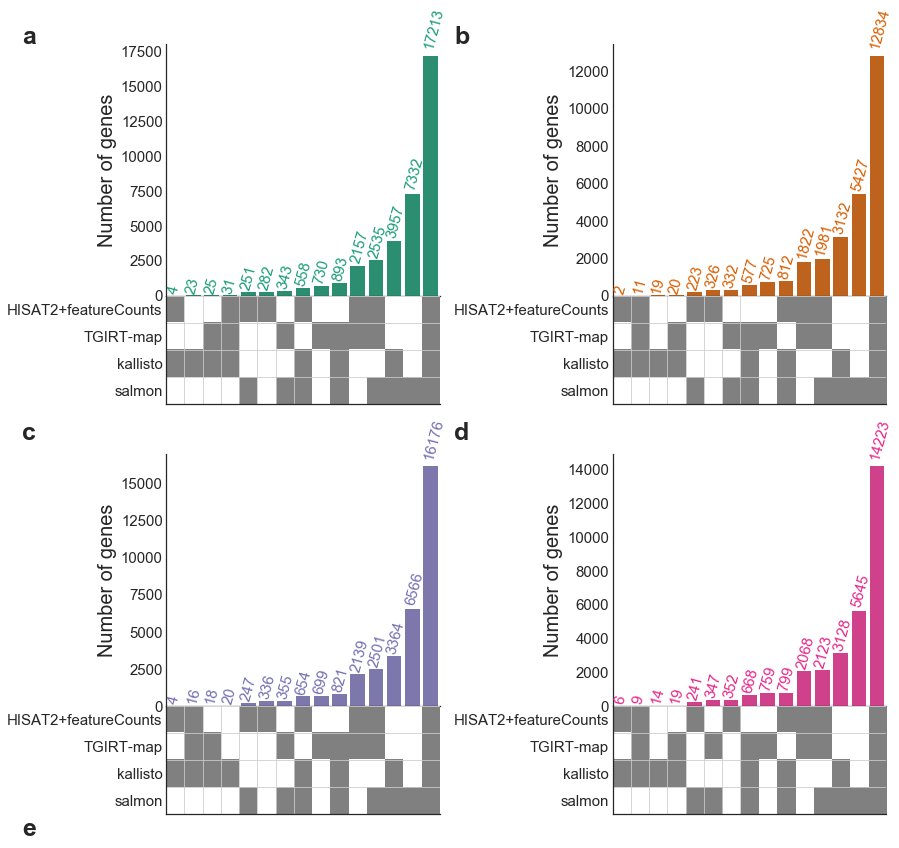

In [20]:
plt.rc('font',size=15)
plt.rc('ytick',labelsize=15)
plt.rc('axes',labelsize=20)
fig = plt.figure(figsize=(10,10))
color_list = sns.color_palette('Dark2',4)

bar_height = 0.35
ax_width = 0.38
dots_height = 0.5 - bar_height

bar_axes = [[0, 1-bar_height, ax_width, bar_height],
           [1-ax_width, 1- bar_height, ax_width, bar_height],
           [0, 0.43-bar_height, ax_width, bar_height],
           [1-ax_width, 0.43-bar_height, ax_width, bar_height]]
dots_axes = [[0, 0.5, ax_width, dots_height],
            [1-ax_width, 0.5, ax_width, dots_height],
            [0, 0.43-dots_height-bar_height, ax_width, dots_height],
            [1-ax_width, 0.43-dots_height-bar_height, ax_width, dots_height]]


for i, (samplename, d) in enumerate(merge_df.groupby('samplename')):
    ax = fig.add_axes(bar_axes[i])
    ax_dots = fig.add_axes(dots_axes[i])
    color = color_list[i]
    plot_upset(samplename, d, ax, ax_dots, color)
fig.text(-0.2,1,'a',fontsize=25, weight='bold')
fig.text(0.4,1,'b',fontsize=25, weight='bold')
fig.text(-0.2,0.45,'c',fontsize=25, weight='bold')
fig.text(0.4,0.45,'d',fontsize=25, weight='bold')
fig.text(-0.2, -0.1,'e', fontsize=25,weight='bold')
figurename = figurepath+ '/upset_plot.pdf'
fig.savefig(figurename, bbox_inches='tight', transparent = True)

In [21]:
merge_df.samplename.unique()

array(['Sample_A', 'Sample_B', 'Sample_C', 'Sample_D'], dtype=object)